In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os, random, shutil
import PIL
from pathlib import Path
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("drive/MyDrive/Colab_Notebooks/data.rar", outdir="drive/MyDrive/Colab_Notebooks/")

INFO patool: Extracting drive/MyDrive/Colab_Notebooks/data.rar ...
INFO:patool:Extracting drive/MyDrive/Colab_Notebooks/data.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/Colab_Notebooks/data.rar
INFO:patool:running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/Colab_Notebooks/data.rar
INFO patool: ... drive/MyDrive/Colab_Notebooks/data.rar extracted to `drive/MyDrive/Colab_Notebooks/'.
INFO:patool:... drive/MyDrive/Colab_Notebooks/data.rar extracted to `drive/MyDrive/Colab_Notebooks/'.


'drive/MyDrive/Colab_Notebooks/'

## Переименование файлов

In [ ]:
def func_rename_photos(data_folder):
    for folder in os.listdir(data_folder):
        for i, photo in enumerate(os.listdir(data_folder + '//' + folder)):
            os.rename(f'{data_folder}//{folder}//{photo}', f'{data_folder}//{folder}//photo_{i}.jpg')

In [ ]:
func_rename_photos('drive/MyDrive/Colab_Notebooks/data')

## Разделение датасета

In [ ]:
# Функция для разделения на тренировочную и валидационную выборки
def split_data(source_root, target_root):
    '''
    source_root - где находится датасет
    target_root - в какой папке хранить разделенный датасет
    '''
    source_root = Path(source_root)
    target_root = Path(target_root)
    train_size = 0.7
    val_size = 0.15

    for class_name in os.listdir(source_root):
        files = os.listdir(source_root / class_name)
        random.shuffle(files)

        n_total = len(files)
        n_train = int(n_total * train_size)
        n_val = int(n_total * val_size)
        n_test = n_total - n_train - n_val

        splits = {
            'train': files[:n_train],
            'val': files[n_train:n_train+n_val],
            'test': files[n_train+n_val:]
        }

        for subset, subset_files in splits.items():
            dct = target_root / subset / class_name
            dct.mkdir(parents=True, exist_ok=True)
            for f in subset_files:
                shutil.copy(source_root / class_name / f, dct / f)

In [ ]:
split_data('drive/MyDrive/Colab_Notebooks/data', 'drive/MyDrive/Colab_Notebooks/data_split')

In [ ]:
# Функция для подсчета файлов
def total_files(dct):
    total = 0

    for root, dir, file in os.walk(dct):
        total += len(file)

    return total

In [ ]:
print(f'Кол-во файлов в train: {total_files("drive/MyDrive/Colab_Notebooks/data_split/train")}')
print(f'Кол-во файлов в val: {total_files("drive/MyDrive/Colab_Notebooks/data_split/val")}')
print(f'Кол-во файлов в test: {total_files("drive/MyDrive/Colab_Notebooks/data_split/test")}')

Кол-во файлов в train: 477
Кол-во файлов в val: 101
Кол-во файлов в test: 107


In [ ]:
# Дублирование изображение (oversampling)
# def duplicate_files(src_dir, dst_dir, class_name, factor):
#     src = os.path.join(src_dir, class_name)
#     dst = os.path.join(dst_dir, class_name)
#     os.makedirs(dst, exist_ok=True)

#     files = [f for f in os.listdir(src) if f.lower().endswith(('.jpg','.png'))]
#     for f in files:
#         shutil.copy(os.path.join(src, f), os.path.join(dst, f))

#     target_count = len(files) * factor
#     while len(os.listdir(dst)) < target_count:
#         f = random.choice(files)
#         new_name = f"{len(os.listdir(dst))}_{f}"
#         shutil.copy(os.path.join(src, f), os.path.join(dst, new_name))

In [ ]:
# for df in ['train', 'val']:
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'good', factor=1)
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'bad', factor=2)
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'great', factor=2)
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'not_bad', factor=2)

In [ ]:
# print(f'Кол-во файлов в train: {total_files("data_split_oversampled/train")}')
# print(f'Кол-во файлов в val: {total_files("data_split_oversampled/val")}')

Кол-во файлов в train: 514
Кол-во файлов в val: 134


## Предобработка данных

In [3]:
# функция применения clahe для улучшения контрастности и удаление теней
def apply_clahe_pil(img):
    img = (img * 255).astype('uint8') if img.max() <= 1.0 else img.astype('uint8') #
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5., tileGridSize=(32,32))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb.astype('float32')

def preprocess_with_clahe(x):
    x_uint8 = (x.astype(np.float32))
    if x_uint8.max() <= 1.0:
        x_uint8 = (x_uint8 * 255).astype('uint8')
    else:
        x_uint8 = x_uint8.astype('uint8')
    rgb = apply_clahe_pil(x_uint8)
    return tf.keras.applications.mobilenet_v3.preprocess_input(rgb)

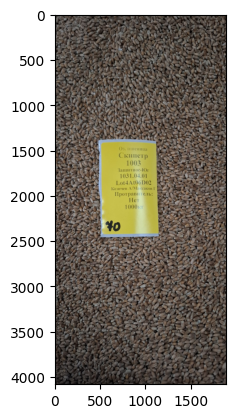

In [4]:
photo_before_clahe = cv2.imread('drive/MyDrive/Colab_Notebooks/data_split/train/good/photo_0.jpg')
photo_before_clahe = cv2.cvtColor(photo_before_clahe, cv2.COLOR_BGR2RGB)

plt.imshow(photo_before_clahe)
plt.show()

L-channel mean before: 85.29787165396944
L-channel mean after : 124.24567


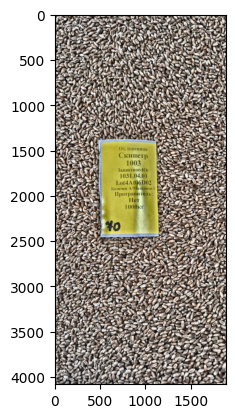

In [5]:
photo_after_clahe = apply_clahe_pil(photo_before_clahe.astype('uint8'))

print("L-channel mean before:", photo_before_clahe.mean())
print("L-channel mean after :", photo_after_clahe.mean())

plt.imshow(photo_after_clahe.astype('uint8'))
plt.show()

In [6]:
# функция, которая создает маску и возвращает ее, она убирает ненужный фон и лишние объекты
def create_seed_mask(img, lower_seed=np.array([0,0,0]), upper_seed=np.array([180,250,250])):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv, lower_seed, upper_seed)

    mask = cv2.medianBlur(mask, 5)

    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask

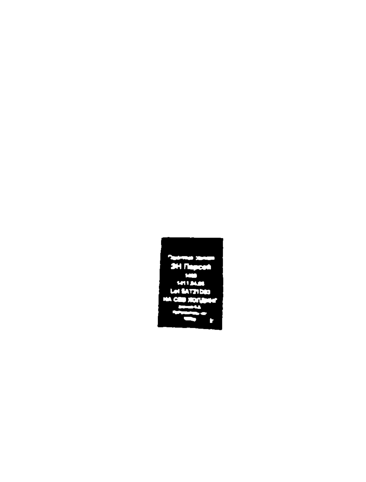

In [7]:
img_path = "drive/MyDrive/Colab_Notebooks/data_split/train/good/photo_118.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = create_seed_mask(img)

plt.figure(figsize=(6,6))
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# старая функция предобработки данных, обрабатывает изображение целиком и возвращает генератор

# def preprocess_seed_image(img, target_size=(224,224)):
#     mask = create_seed_mask(img)
#     mask_uint8 = (mask > 0).astype(np.uint8) * 255

#     img_masked = cv2.bitwise_and(img, img, mask=mask_uint8)


#     img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img_gray_rgb = cv2.merge([img_gray, img_gray, img_gray])

#     img_clahe = apply_clahe_pil(img_gray_rgb)

#     img_resized = cv2.resize(img_clahe, target_size)
#     img_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(img_resized)

#     return img_preprocessed

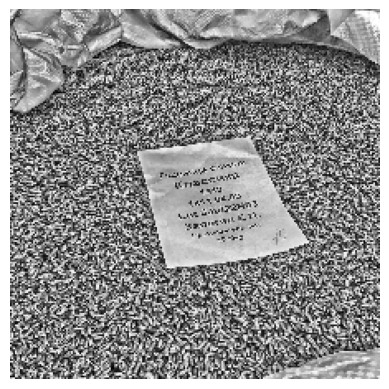

In [ ]:
# img_path = "data_split/train/good/photo_1.jpg"
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# img_preprocessed = preprocess_seed_image(img)

# img_display = ((img_preprocessed - img_preprocessed.min()) /
#                (img_preprocessed.max() - img_preprocessed.min()) * 255).astype(np.uint8)

# plt.imshow(img_display, cmap='gray')
# plt.axis('off')
# plt.show()

In [ ]:
!pip install patchify

In [49]:
from patchify import patchify

# разделяет изображение на патчи
def extract_patches(img, patch_size=(224,224), step=None, max_patches=None):
    h, w, _ = img.shape
    ph, pw = patch_size

    positions = [(i, j) for i in range(0, h - ph + 1, ph)
                          for j in range(0, w - pw + 1, pw)]

    if len(positions) == 0:
        patch = cv2.resize(img, patch_size)
        return [patch]

    selected_positions = random.sample(positions, min(max_patches, len(positions)))

    patches = [img[i:i+ph, j:j+pw, :] for i,j in selected_positions]

    return patches


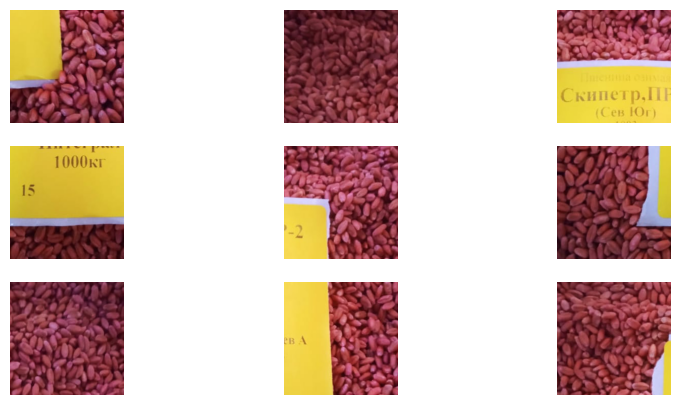

In [55]:
img_path = "drive/MyDrive/Colab_Notebooks/data_split/train/good/photo_101.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

patches = extract_patches(img, patch_size=(224,224), max_patches=9)

plt.figure(figsize=(10,5))
for i, p in enumerate(patches[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(p)
    plt.axis("off")
plt.show()

In [ ]:
# берет первый патч у изображения, обрабатывает его и возвращает генератор
# def preprocess_patch_image(img, target_size=(224,224)):
#     patches = extract_patches(img, patch_size=target_size, max_patches=1)
#     patch = patches[0]

#     mask = create_seed_mask(patch)
#     mask_uint8 = (mask > 0).astype(np.uint8) * 255
#     img_masked = cv2.bitwise_and(patch, patch, mask=mask_uint8)

#     img_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)
#     img_gray_rgb = cv2.merge([img_gray, img_gray, img_gray])
#     img_clahe = apply_clahe_pil(img_gray_rgb)

#     img_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(img_clahe)
#     return img_preprocessed

In [56]:
# создаем список классов и записываем их в порядке возрастания, это пригодится для функции потерь
ordered_classes = ['bad', 'not_bad', 'good', 'great']

def preprocessing_data(train_dir, val_dir, target_size=(1024, 1024), batch_size=16):
    train_datagen = ImageDataGenerator(
        preprocessing_function=lambda img: img,
        rotation_range=10,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.2,
        brightness_range=(0.6, 1.2),
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=lambda img: img
    )

    train_gen = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        classes=ordered_classes
    )

    val_gen = val_datagen.flow_from_directory(
        directory=val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        classes=ordered_classes
    )

    return train_gen, val_gen

In [57]:
train_gen, val_gen = preprocessing_data('drive/MyDrive/Colab_Notebooks/data_split/train',
                                        'drive/MyDrive/Colab_Notebooks/data_split/val',
                                        target_size=(1024, 1024),
                                        batch_size=8)

Found 477 images belonging to 4 classes.
Found 101 images belonging to 4 classes.


In [13]:
# создаем веса классов, нужжно для борьбы с дисбалансом
labels = train_gen.labels
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
)

class_weights_dict = dict(enumerate(class_weights))
print('Class weights:', class_weights_dict)

Class weights: {0: 1.125, 1: 0.8517857142857143, 2: 0.6411290322580645, 3: 2.65}


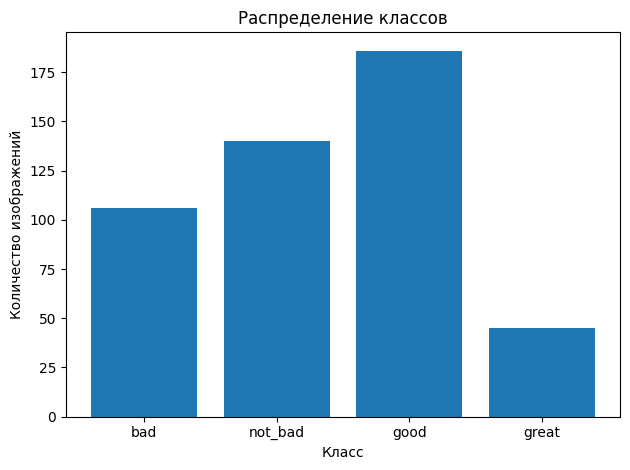

In [19]:
labels = train_gen.classes
class_names = list(train_gen.class_indices.keys())

plt.hist(labels, bins=np.arange(len(class_names)+1)-0.5, rwidth=0.8)
plt.xticks(np.arange(len(class_names)), labels=class_names)
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.title("Распределение классов")
plt.tight_layout()
plt.show()

In [20]:
print(class_names)

['bad', 'not_bad', 'good', 'great']


## Обучение

In [16]:
# функция потерь, учитывает насколько далеко модель предсказала класс, используется в обучении
def ordinal_focal_loss(gamma=2.0, alpha=0.25, k=0.5):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred,
                                  tf.keras.backend.epsilon(),
                                  1. - tf.keras.backend.epsilon())

        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_weight  = alpha * tf.pow(1 - y_pred, gamma)

        true_idx = tf.cast(tf.argmax(y_true, axis=1), tf.float32)
        pred_idx = tf.cast(tf.range(tf.shape(y_pred)[1]), tf.float32)

        dist_matrix = tf.abs(
            tf.expand_dims(true_idx, axis=1) - tf.expand_dims(pred_idx, axis=0)
        )

        weight = focal_weight * (1.0 + k * dist_matrix)

        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss


## Модель с MIL агрегацией

In [17]:
# функция, которая обрабатывает мешок патчей
def preprocess_patch_bag(img, target_size=(224,224), max_patches=None):
    patches = extract_patches(img, patch_size=target_size, max_patches=max_patches)
    bag = []
    for patch in patches:
        mask = create_seed_mask(patch)
        mask_uint8 = (mask > 0).astype(np.uint8) * 255
        img_masked = cv2.bitwise_and(patch, patch, mask=mask_uint8)

        img_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)
        img_gray_rgb = cv2.merge([img_gray, img_gray, img_gray])
        img_clahe = apply_clahe_pil(img_gray_rgb)

        img_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(img_clahe)
        bag.append(img_preprocessed)

    return np.array(bag)

In [18]:
# функция, которая создает генератор для модель используя функцию предобработки мешка патчей
def mil_generator(generator, target_size=(224,224), max_patches=None):
    while True:
        batch_x, batch_y = next(generator)
        bags = []
        for img in batch_x:
            bag = preprocess_patch_bag(img, target_size=target_size, max_patches=max_patches)
            bags.append(bag)
        max_len = max(len(b) for b in bags)
        bags_padded = np.zeros((len(bags), max_len, target_size[0], target_size[1], 3), dtype=np.float32)
        for i, b in enumerate(bags):
            bags_padded[i, :len(b)] = b
        yield bags_padded, batch_y


In [19]:
train_mil_gen = mil_generator(train_gen, target_size=(224, 224), max_patches=10)
val_mil_gen   = mil_generator(val_gen, target_size=(224, 224), max_patches=10)

In [20]:
# функция которая создает генератор с весами, так как такие требования у tensorflow последней версс
def add_sample_weights(generator, class_weights):
    for x, y in generator:
        if y.ndim > 1 and y.shape[-1] > 1:
            class_indices = np.argmax(y, axis=-1)
        else:
            class_indices = y

        weights = np.array([class_weights[c] for c in class_indices])

        yield x, y, weights

In [21]:
train_mil_gen_w = add_sample_weights(train_mil_gen, class_weights)
val_mil_gen_w = add_sample_weights(val_mil_gen, class_weights)

## Создание и компиляция модели

In [22]:
input_shape = (224, 224, 3)

# базовая модель на основе mobilenev3large
base_model = applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

In [25]:
num_classes = len(ordered_classes)

patch_input = keras.Input(shape=(224,224,3))
patch_features = base_model(patch_input, training=False)
patch_features = GlobalAveragePooling2D()(patch_features)
patch_encoder = keras.Model(patch_input, patch_features)

bag_input = keras.Input(shape=(None, 224,224,3))

encoded_patches = keras.layers.TimeDistributed(patch_encoder)(bag_input)

att_logits = Dense(1, activation='tanh',
                   kernel_regularizer=tf.keras.regularizers.l2(1e-4))(encoded_patches)
att_weights = tf.keras.layers.Softmax(axis=1, name='att_softmax')(att_logits)
weighted = keras.layers.Multiply()([att_weights, encoded_patches])
bag_representation = keras.layers.Lambda(lambda z: tf.reduce_sum(z, axis=1), name='att_pool')(weighted)

x = Dense(1024, activation='relu')(bag_representation)
x = keras.layers.Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = keras.Model(bag_input, output)

model.compile(
    optimizer=Adam(1e-4),
    loss=ordinal_focal_loss(),
    metrics=['accuracy']
)

In [ ]:
# Старая модель, пригодная до внедрения патчей

# base_model.trainable = False
# num_classes = len(list(train_gen.class_indices))

# inputs = keras.Input(shape=input_shape)
# x = base_model(inputs, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# x = keras.layers.Dropout(0.3)(x)
# outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# model = Model(inputs, outputs)

# model.compile(
#         optimizer=Adam(learning_rate=1e-4),
#         loss=ordinal_focal_loss(),
#         metrics=['accuracy']
# )

In [26]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 224, │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 960) │  2,996,352 │ input_layer_4[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 1)   │        961 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_softmax         │ (None, None, 1)   │          0 │ dense_2[0][0]     │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, None, 960) │          0 │ att_softmax[0][0… │
│ (Multiply)          │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_pool (Lambda)   │ (None, 960)       │          0 │ multiply_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1024)      │    984,064 │ att_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │      4,100 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,985,477 (15.20 MB)

 Trainable params: 3,961,077 (15.11 MB)

 Non-trainable params: 24,400 (95.31 KB)

## Обучение модели

In [27]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('train_log.csv')
]

In [28]:
model.fit(
    train_mil_gen_w,
    validation_data=val_mil_gen_w,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4743 - loss: 0.1701 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1165s 16s/step - accuracy: 0.4755 - loss: 0.1695 - val_accuracy: 0.6337 - val_loss: 0.0845 - learning_rate: 1.0000e-04
Epoch 2/5
 5/60 ━━━━━━━━━━━━━━━━━━━━ 15:13 17s/step - accuracy: 0.5579 - loss: 0.0948

KeyboardInterrupt: 

In [ ]:
# Размораживаем последние 50 слоев модели и дообучаем ее
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=ordinal_focal_loss(),
              metrics=['accuracy'])

history_fine = model.fit(
    train_mil_gen_w,
    epochs=5,
    validation_data=val_mil_gen_w,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=callbacks
    )

Epoch 1/5
137/137 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.8022

f:\my_files\works\jupyter\testScripts\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - 454s 3s/step - loss: 0.0338 - accuracy: 0.8022 - val_loss: 0.0317 - val_accuracy: 0.7986 - lr: 1.0000e-05
Epoch 2/5
137/137 [==============================] - 318s 2s/step - loss: 0.0273 - accuracy: 0.8242 - val_loss: 0.0297 - val_accuracy: 0.8129 - lr: 1.0000e-05
Epoch 3/5
137/137 [==============================] - 241s 2s/step - loss: 0.0277 - accuracy: 0.8168 - val_loss: 0.0302 - val_accuracy: 0.7986 - lr: 1.0000e-05
Epoch 4/5
137/137 [==============================] - 287s 2s/step - loss: 0.0292 - accuracy: 0.8168 - val_loss: 0.0309 - val_accuracy: 0.8201 - lr: 1.0000e-05
Epoch 5/5
137/137 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.8480
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
137/137 [==============================] - 194s 1s/step - loss: 0.0252 - accuracy: 0.8480 - val_loss: 0.0329 - val_accuracy: 0.8201 - lr: 1.0000e-05


## Проверка модели

In [39]:
def predict_single_image_mil(model, img_path, class_names, target_size=(224,224), max_patches=5):
    if isinstance(img_path, str):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = img_path

    bag = preprocess_patch_bag(img, target_size=target_size, max_patches=max_patches)
    bag = np.expand_dims(bag, axis=0)

    pred_vector = model.predict(bag, verbose=0)[0]
    pred_class = np.argmax(pred_vector)
    pred_label = class_names[pred_class]

    return pred_label, pred_vector

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_mil_model(model, val_gen, class_names, target_size=(224,224), max_patches=5):
    all_preds = []
    all_true = []

    for i in range(len(val_gen)):
        batch_x, batch_y = val_gen[i]
        for j in range(len(batch_x)):
            img = batch_x[j].astype('uint8')
            true_label = np.argmax(batch_y[j])

            bag = preprocess_patch_bag(img, target_size=target_size, max_patches=max_patches)
            bag = np.expand_dims(bag, axis=0)
            pred_vector = model.predict(bag, verbose=0)[0]

            all_preds.append(np.argmax(pred_vector))
            all_true.append(true_label)

    print("Classification Report:")
    print(classification_report(all_true, all_preds, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(all_true, all_preds))

    return np.array(all_true), np.array(all_preds)


In [42]:
all_true, all_preds = evaluate_mil_model(model, val_gen, ordered_classes, max_patches=10)

Classification Report:
              precision    recall  f1-score   support

         bad       0.36      0.82      0.50        22
     not_bad       0.49      0.60      0.54        30
        good       1.00      0.17      0.30        40
       great       1.00      0.78      0.88         9

    accuracy                           0.50       101
   macro avg       0.71      0.59      0.55       101
weighted avg       0.71      0.50      0.46       101

Confusion Matrix:
[[18  4  0  0]
 [12 18  0  0]
 [18 15  7  0]
 [ 2  0  0  7]]


In [58]:
att_model = keras.Model(inputs=model.input,
                        outputs=model.get_layer("att_softmax").output)

def visualize_attention(img, model, att_model, patch_size=(224,224), max_patches=10):
    patches = extract_patches(img, patch_size=patch_size, max_patches=max_patches)

    bag = preprocess_patch_bag(img, target_size=patch_size, max_patches=max_patches)
    bag = np.expand_dims(bag, axis=0)

    att_w = att_model.predict(bag, verbose=0)[0]
    att_w = att_w.squeeze()

    att_w = (att_w - att_w.min()) / (att_w.max() - att_w.min() + 1e-6)

    plt.figure(figsize=(10, 10))
    for i, patch in enumerate(patches):
        plt.subplot(int(np.ceil(len(patches)/3)), 3, i+1)
        plt.imshow(patch.astype("uint8"))
        plt.title(f"w={att_w[i]:.2f}")
        plt.axis("off")
    plt.show()


Предсказанный класс: bad


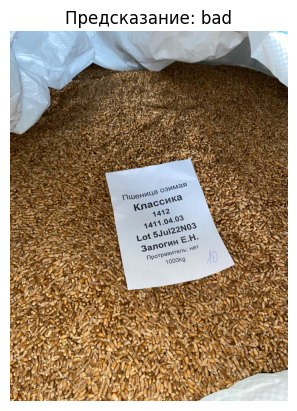

In [45]:
img_path = 'drive/MyDrive/Colab_Notebooks/data_split/val/good/photo_1.jpg'

img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

label, probs = predict_single_image_mil(model, img_path, ordered_classes)

print(f"Предсказанный класс: {label}")

plt.imshow(keras.preprocessing.image.load_img(img_path))
plt.title(f"Предсказание: {label}")
plt.axis('off')
plt.show()

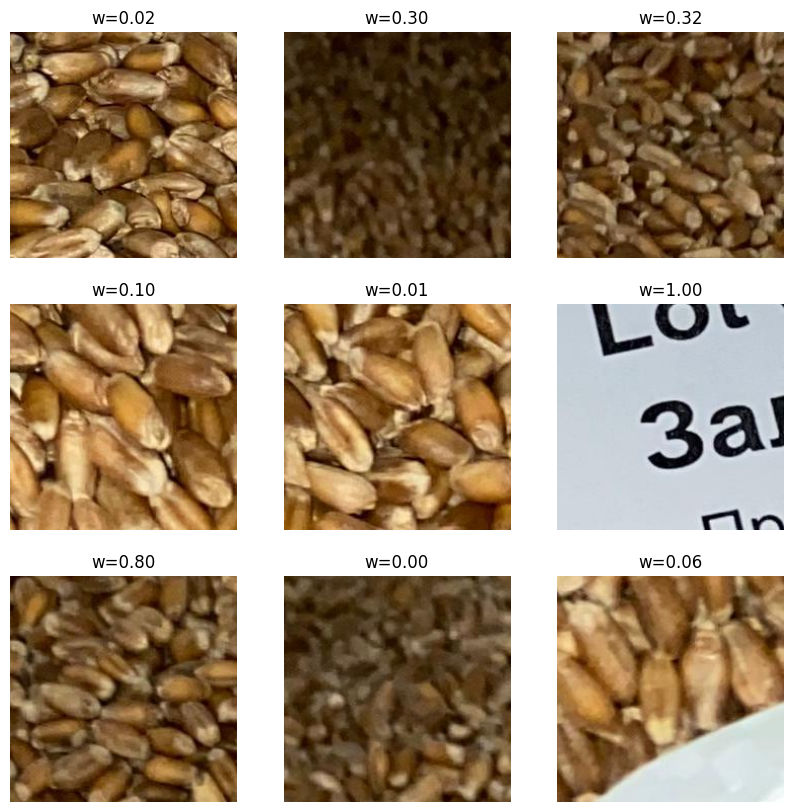

In [59]:
img_path = 'drive/MyDrive/Colab_Notebooks/data_split/val/good/photo_1.jpg'

img = np.array(Image.open(img_path).convert("RGB"))

visualize_attention(img, model, att_model, max_patches=10)

In [ ]:
# функция grad cam, показывает интерпретацию модели, щас не подходит, так как обучал по патчам

# def make_gradcam_heatmap(img_path, model, preprocess_fn=None, class_names=None):
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
#     img_array = tf.keras.preprocessing.image.img_to_array(img)

#     if preprocess_fn is not None:
#         img_array = preprocess_fn(img_array)

#     img_array = np.expand_dims(img_array, axis=0)

#     base_model = model.get_layer("MobilenetV3large")
#     last_conv_layer = base_model.get_layer("last_layet")

#     grad_model = tf.keras.models.Model(
#         inputs=base_model.input,
#         outputs=[last_conv_layer.output, base_model.output]
#     )

#     with tf.GradientTape() as tape:
#         conv_outputs, preds_base = grad_model(img_array, training=False)
#         x = tf.keras.layers.GlobalAveragePooling2D()(conv_outputs)
#         x = model.layers[-3](x)
#         x = model.layers[-2](x)
#         preds = model.layers[-1](x)
#         class_index = tf.argmax(preds[0])
#         loss = preds[:, class_index]

#     grads = tape.gradient(loss, conv_outputs)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     conv_outputs = conv_outputs[0].numpy()
#     pooled_grads = pooled_grads.numpy()

#     for i in range(pooled_grads.shape[-1]):
#         conv_outputs[:, :, i] *= pooled_grads[i]

#     heatmap = np.mean(conv_outputs, axis=-1)
#     heatmap = np.maximum(heatmap, 0)
#     heatmap /= np.max(heatmap) + 1e-8

#     img_orig = cv2.imread(img_path)
#     img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
#     heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
#     heatmap_resized = np.uint8(255 * heatmap_resized)
#     heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
#     superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_colored, 0.4, 0)

#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow(img_orig)
#     plt.title("Original")
#     plt.axis("off")

#     plt.subplot(1, 2, 2)
#     if class_names:
#         label = class_names[class_index.numpy()]
#     else:
#         label = f"class {class_index.numpy()}"
#     plt.imshow(superimposed_img)
#     plt.title(f"Grad-CAM ({label})")
#     plt.axis("off")
#     plt.show()

#     return class_index.numpy(), preds[0].numpy()


In [33]:
# class_names = list(train_gen.class_indices.keys())
# make_gradcam_heatmap_mil('data_split/val/not_bad/photo_108.jpg', pred_model, preprocess_fn=preprocess_with_clahe, class_names=class_names)